The basic idea of this dimensionality reduction is to try and catch the underlying seasonality of the data.
For each chipid, we ideally would have 12 months of information. However, we don't know a priori what combination of months is more representative for the AGBM. Therefore, we can use a simple linear feature extractor to try and get some sort of "main seasonality" feature. We should, nevertheless, compare our model to a simpler baseline, e. g. using August for every chipid.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import os
import torch

from bioMass.dataloader import train_df, read_yearly_tiffs

def plot_months(data, months_list, band_no, cmap='viridis'):
    
    fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(10, 8))
    list(map(lambda axi: axi.set_axis_off(), ax.ravel()))
    plt.tight_layout()


    for month, month_data in zip(months_list, data):
        col = month%4
        row = month//4
        ax[row][col].imshow(month_data[band_no], cmap=cmap)
        
    plt.show()
    
    return

%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
def get_warm_data(data, months_list):
    warm_months = [0, 8, 9, 10, 11] # Sep, May, June, July, August
    
    data_warm = []
    months_list_warm = []
    for m, d in zip(months_list, data):
        if m in warm_months:
            # compute number of zeros and only append if more than 60%
            pct_zeros = (d==0).sum()/len(d.flatten())
            # if pct_zeros>0.6:
            data_warm.append(d)
            months_list_warm.append(m)
                
#     if len(months_list_warm)==0:
#         data_warm.append(np.zeros_like(d))
#         months_list_warm.append(-1)
    
    return data_warm, months_list_warm 

In [26]:
data, months_list, agbm = read_yearly_tiffs('1b7a76f8', 'S2')
data, months_list = get_warm_data(data, months_list)
months_list

[8, 9, 10, 11]

In [27]:
np.array(data).shape

(4, 14, 256, 256)

In [28]:
data[0].shape

(14, 256, 256)

In [29]:
np.zeros_like(data[0]).shape

(14, 256, 256)

In [30]:
(data[0]==0).sum()/len(data[0].flatten())

0.7101647513253349

In [31]:
len(data)

4

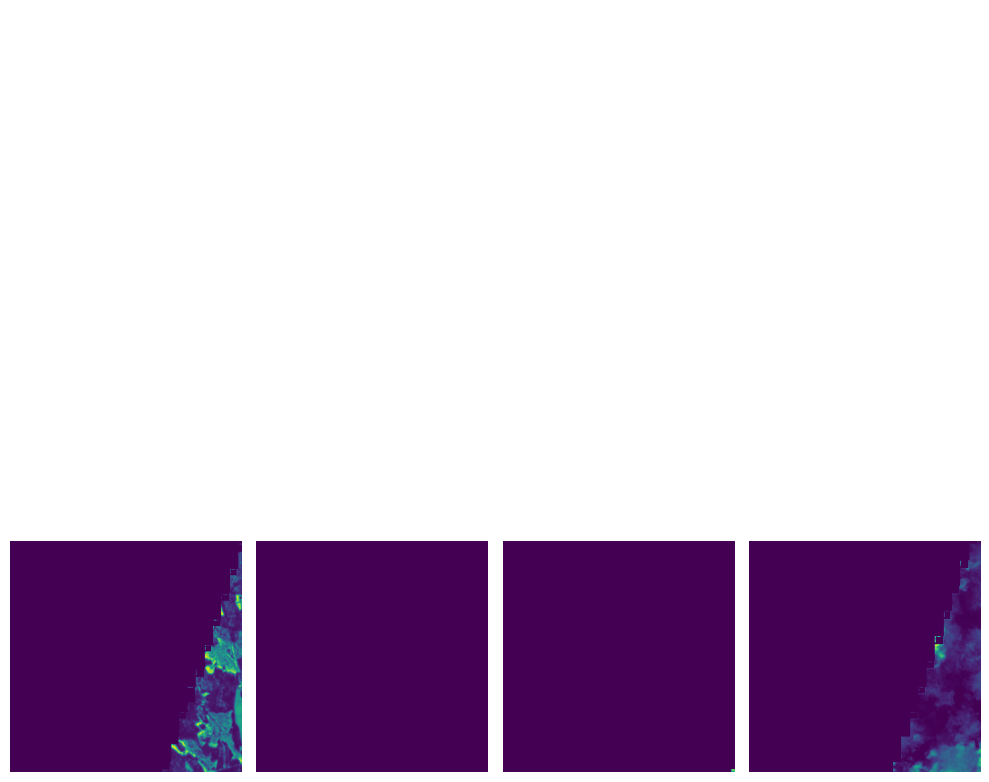

In [32]:
band_no = 0
plot_months(data, months_list, band_no)

In [74]:
single_band_year = np.array(data)[:, band_no, :, :]
aux_shape = single_band_year[0].shape

zeros_per_month = [(x==0).sum() for x in single_band_year]
zeros_per_month = np.array(zeros_per_month)/(256*256) 

single_band_year = [single_band_year[x] for x in range(len(single_band_year)) if zeros_per_month[x]<0.4]

if len(single_band_year)==0:
    aux = np.zeros(tuple(aux_shape))

In [75]:
aux.shape

(256, 256)

In [34]:
single_band_year = np.array(data)[:, band_no, :, :]
single_band_year = single_band_year.reshape((len(single_band_year), 256*256)).T

zeros_per_month = [(x==0).sum() for x in single_band_year]
zeros_per_month = np.array(zeros_per_month)/(256*256) 

zeros_per_month

array([6.10351562e-05, 6.10351562e-05, 6.10351562e-05, ...,
       1.52587891e-05, 1.52587891e-05, 1.52587891e-05])

In [37]:
single_band_year.shape

(65536, 4)

In [11]:
from sklearn.decomposition import PCA

single_band_year = np.array(data)[:, band_no, :, :]
single_band_year = single_band_year.reshape((len(single_band_year), 256*256)).T
single_band_year = (single_band_year - single_band_year.mean()) / (single_band_year.std()  +1e-4)

pca = PCA(n_components=1)

reduced_single_band = pca.fit_transform(single_band_year)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

print(reduced_single_band.shape)

NameError: name 'band_no' is not defined

(-0.5, 255.5, 255.5, -0.5)

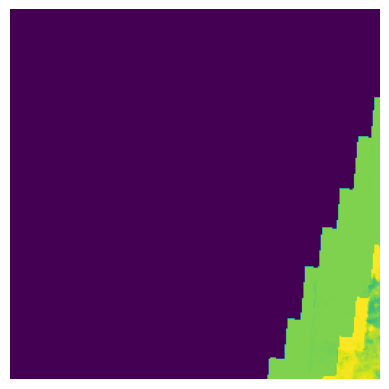

In [43]:
plt.imshow(reduced_single_band[:, 0].flatten().reshape(256, 256))
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

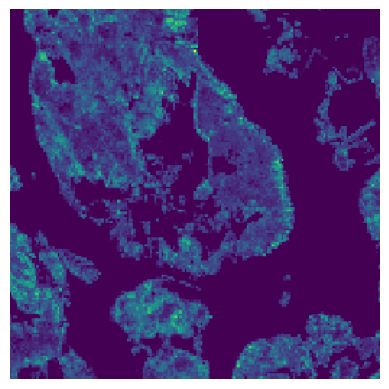

In [44]:
plt.imshow(agbm)
plt.axis('off')

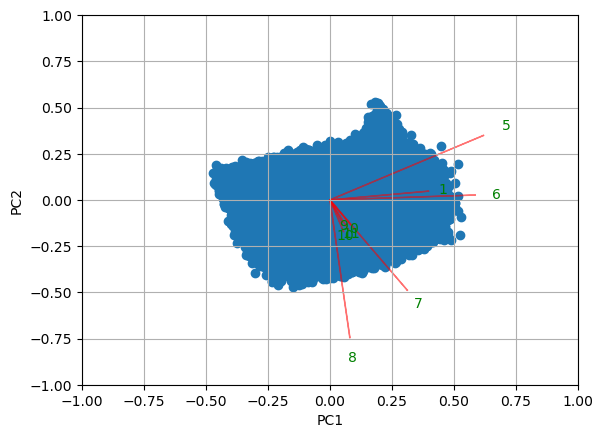

In [116]:
def myplot(score,coeff,labels=months_list):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

#Call the function. Use only the 2 PCs.
myplot(reduced_single_band[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()